# Data Transformation Part

## Imports

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Read in raw data

In [3]:
df =  pd.read_csv('raw_data.csv')
df.columns =["start", "total", 'overhead', 'duration']
df.head()

,start,total,overhead,duration
0,198,200,1.605530,519
1,199,200,2.183017,379
2,198,200,1.738318,426
3,199,200,1.672397,342
4,198,200,1.623861,316


## Divide data to create samples

In [4]:
df['c'] = df['total'].diff()
df_filtered = df[df['c'] != 0]

In [5]:
index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
print(len(index_list))
print('\n')
print(index_list)

155


[0, 488, 1400, 2049, 3095, 4357, 5836, 7069, 8112, 9380, 10387, 11042, 11969, 12622, 13542, 14572, 15737, 16762, 17684, 18869, 19817, 20954, 22256, 23394, 24759, 26160, 27499, 28710, 29676, 30359, 31236, 31922, 32953, 34313, 35763, 37158, 38767, 40147, 41726, 43438, 45022, 46669, 48253, 49663, 50724, 52092, 53102, 54364, 55426, 56791, 57797, 59121, 60546, 61902, 62969, 63638, 64558, 65763, 67181, 68721, 70359, 72077, 73635, 75149, 76644, 78107, 79825, 81569, 83106, 84588, 86267, 87980, 89707, 91211, 92652, 93849, 95426, 97070, 98589, 100311, 101857, 103048, 104442, 105911, 107289, 108925, 110323, 111539, 112882, 114094, 115018, 116081, 117331, 118416, 119320, 120409, 121285, 121976, 122934, 124191, 125108, 126330, 127241, 127942, 128889, 130144, 131132, 132403, 133371, 134558, 135863, 136993, 137970, 138632, 139602, 140256, 141314, 142587, 143623, 144895, 145909, 146614, 147564, 148924, 150488, 152225, 153769, 155064, 156598, 158312, 160041, 161994, 163717, 165461, 167151, 168858

In [6]:
l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

In [7]:
len(list_of_dfs)

155

## Create a new dataframe from statistics of each sample

In [8]:
data = pd.DataFrame(columns=['median', 'q1', 'q3', 'p90', 'cars'])
median, q1, q3, p90, mode = [], [], [], [], []

In [9]:
for frame in list_of_dfs:
    median.append(frame['overhead'].mean())
    q1.append(frame['overhead'].quantile(q =.25))
    q3.append(frame['overhead'].quantile(q =.75))
    p90.append(frame['overhead'].quantile(q =.9))
    mode.append(frame['total'].mode()[0]) # mode returns a series so we need to specify which value to return

In [10]:
data['median'] = median
data['q1'] = q1
data['q3'] = q3
data['p90']= p90
data['cars'] = mode
data

,median,q1,q3,p90,cars
0,1.654107,1.306363,1.881764,2.231246,200
1,1.692571,1.316283,1.950820,2.324354,300
2,1.629607,1.283480,1.874575,2.143453,200
3,1.715201,1.331584,1.969039,2.369109,300
4,1.791137,1.351439,2.085545,2.486877,400
...,...,...,...,...,...
150,2.028469,1.389824,2.346458,3.081876,600
151,1.889810,1.392663,2.160634,2.717248,500
152,2.082111,1.412053,2.380013,3.182939,600
153,2.170848,1.365687,2.530237,3.445871,700


---

# Clustering Part

In [11]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) > 2:

        silhouette_scores = []

        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        # print(clusters_range)
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = model
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            # print(labels)
            try: 
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
        plt.plot(silhouette_range[:], silhouette_scores[:])
        plt.xlabel('Number Of Clusers')
        plt.ylabel('Silhouette Score')
#         plt.savefig(folder + 'silhouette_'+ save_graph_name +'.png')
        plt.show()
        plt.close() 
        max_score = max(silhouette_scores)
        for i in results_dict:
            if i[1] == max_score:
                print("The highest silhouette scores(" + str(max_score) + ") is for " + str(i[0]) + " clusers")
                return int(i[0])
    else:
        print('couldnt get the scores, plz help')
        print('returning number of clusters = ' + str(n_clusters_min))
        return n_clusters_min

In [13]:
test_normal = data[['median', 'q1', 'q3', 'p90']].to_numpy()
test_normal_list = np.split(test_normal, 5) # splitting data to simulate data stream

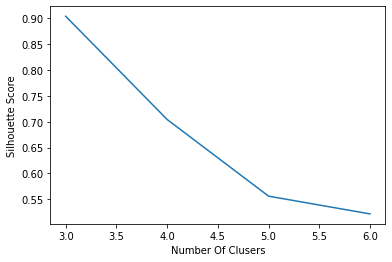

The highest silhouette scores(0.9042070533068344) is for 3 clusers


In [14]:
model = Birch(n_clusters=None, threshold=0.2)

for i in test_normal_list:
    model.partial_fit(i)

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model, test_normal, 3, 6)

model.set_params(n_clusters = n)
model.partial_fit()
    
labels = model.predict(test_normal)

In [17]:
data_to_plot = data.to_numpy()

Text(0.5, 0.98, 'Clustering without Average')

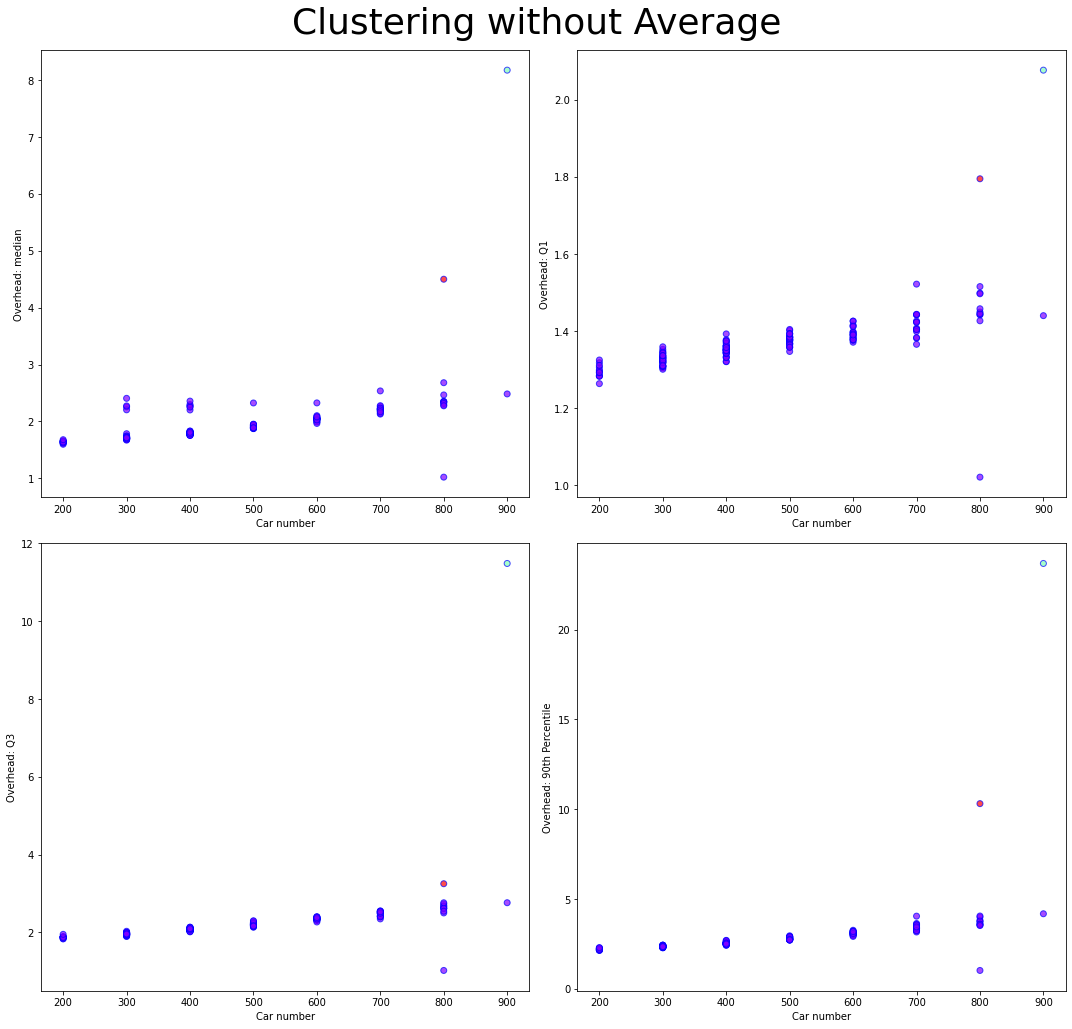

In [18]:
figure, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
axs[0,0].scatter(data_to_plot[:,4], data_to_plot[:,0], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')  
axs[0,0].set_ylabel('Overhead: median')
axs[0,0].set_xlabel('Car number')

axs[0,1].scatter(data_to_plot[:,4], data_to_plot[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')    
axs[0,1].set_ylabel('Overhead: Q1')
axs[0,1].set_xlabel('Car number')

axs[1,0].scatter(data_to_plot[:,4], data_to_plot[:,2], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')    
axs[1,0].set_ylabel('Overhead: Q3')
axs[1,0].set_xlabel('Car number')

axs[1,1].scatter(data_to_plot[:,4], data_to_plot[:,3], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')
axs[1,1].set_ylabel('Overhead: 90th Percentile')
axs[1,1].set_xlabel('Car number')

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
figure.suptitle('Clustering without Average', fontsize=36)

## SOME DATA ANALYSIS IS NEEDED 

In [20]:
data.head()

,median,q1,q3,p90,cars
0,1.654107,1.306363,1.881764,2.231246,200
1,1.692571,1.316283,1.950820,2.324354,300
2,1.629607,1.283480,1.874575,2.143453,200
3,1.715201,1.331584,1.969039,2.369109,300
4,1.791137,1.351439,2.085545,2.486877,400


In [21]:
maxValuesObj = data.max()
print(maxValuesObj)

median      8.173832
q1          2.076400
q3         11.482347
p90        23.676601
cars      900.000000
dtype: float64


### Delete the outliers

In [22]:
data.idxmax(axis=0, skipna=True) # get the indexes of maximum values

median    145
q1        145
q3        145
p90       145
cars      143
dtype: int64

In [23]:
dropped_data = data.drop([145])
dropped_data.head()

,median,q1,q3,p90,cars
0,1.654107,1.306363,1.881764,2.231246,200
1,1.692571,1.316283,1.950820,2.324354,300
2,1.629607,1.283480,1.874575,2.143453,200
3,1.715201,1.331584,1.969039,2.369109,300
4,1.791137,1.351439,2.085545,2.486877,400


In [24]:
dropped_data.idxmax(axis=0, skipna=True) # get the indexes of maximum values

median    146
q1        146
q3        146
p90       146
cars      143
dtype: int64

In [25]:
dropped_data.drop([146], inplace = True)

In [26]:
data.idxmin(axis=0, skipna=True)

median    154
q1        154
q3        154
p90       154
cars        0
dtype: int64

In [27]:
dropped_data.drop([154], inplace = True)

In [28]:
test_data_2 = dropped_data[['median', 'q1', 'q3', 'p90']].to_numpy()

In [29]:
len(test_data_2)

152

In [30]:
test_data_2_list = np.split(test_data_2, 4)

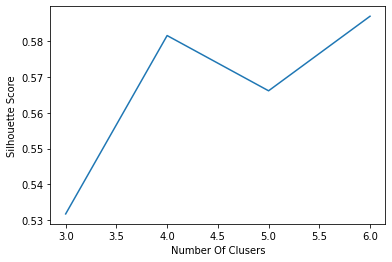

The highest silhouette scores(0.5870334619707293) is for 6 clusers


In [31]:
model2 = Birch(n_clusters=None, threshold=0.2)

for i in test_data_2_list:
    model2.partial_fit(i)

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model2, test_data_2, 3, 6)

model2.set_params(n_clusters = n)
model2.partial_fit()
    
labels = model2.predict(test_data_2)

In [32]:
data_to_plott_2 = dropped_data.to_numpy()

In [33]:
# data_to_plott_2

Text(0.5, 0.98, 'Clustering without Average')

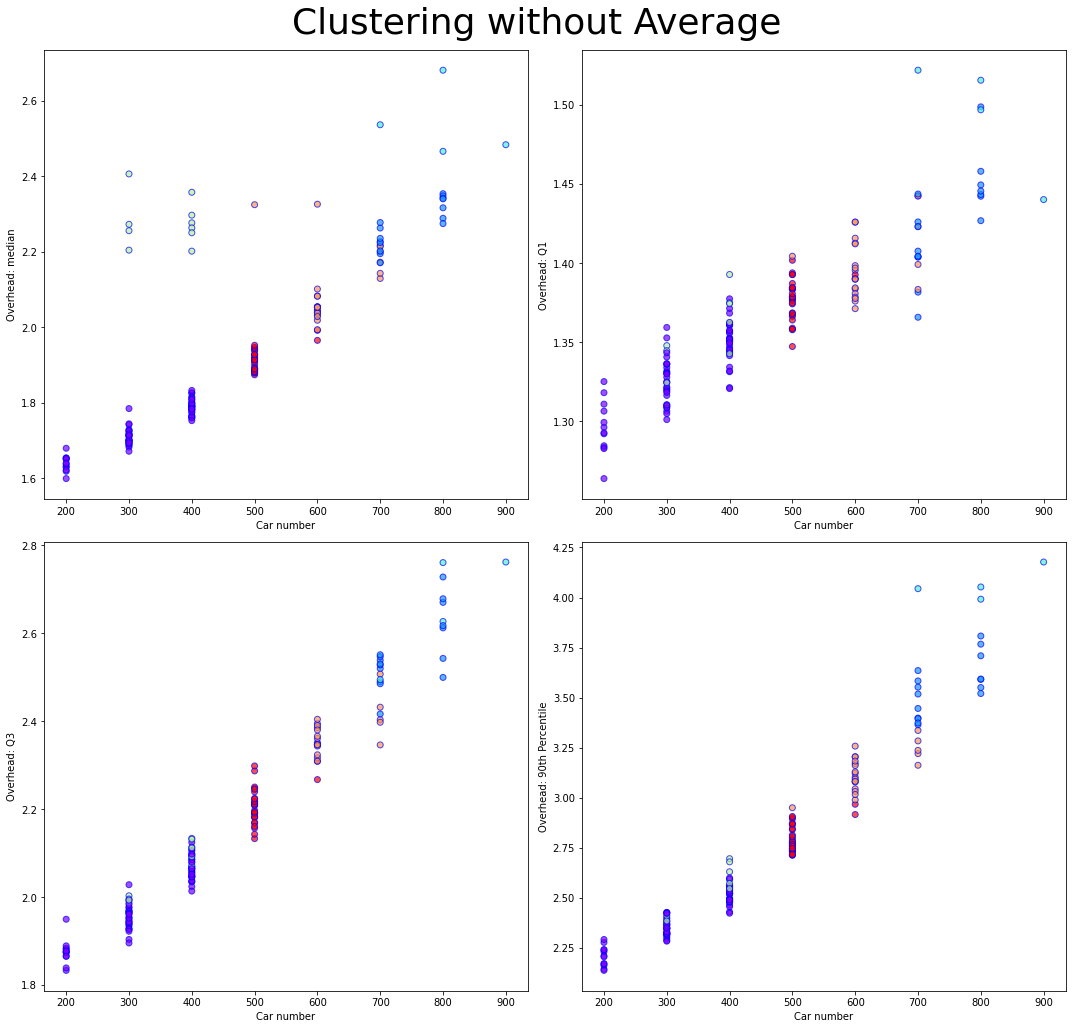

In [34]:
figure, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
axs[0,0].scatter(data_to_plott_2[:,4], data_to_plott_2[:,0], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')  
axs[0,0].set_ylabel('Overhead: median')
axs[0,0].set_xlabel('Car number')

axs[0,1].scatter(data_to_plott_2[:,4], data_to_plott_2[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')    
axs[0,1].set_ylabel('Overhead: Q1')
axs[0,1].set_xlabel('Car number')

axs[1,0].scatter(data_to_plott_2[:,4], data_to_plott_2[:,2], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')    
axs[1,0].set_ylabel('Overhead: Q3')
axs[1,0].set_xlabel('Car number')

axs[1,1].scatter(data_to_plott_2[:,4], data_to_plott_2[:,3], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')
axs[1,1].set_ylabel('Overhead: 90th Percentile')
axs[1,1].set_xlabel('Car number')

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
figure.suptitle('Clustering without Average', fontsize=36)

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


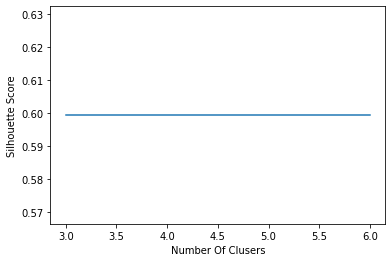

The highest silhouette scores(0.5992839465407208) is for 3 clusers


Text(0.5, 0.98, 'Clustering without Average')

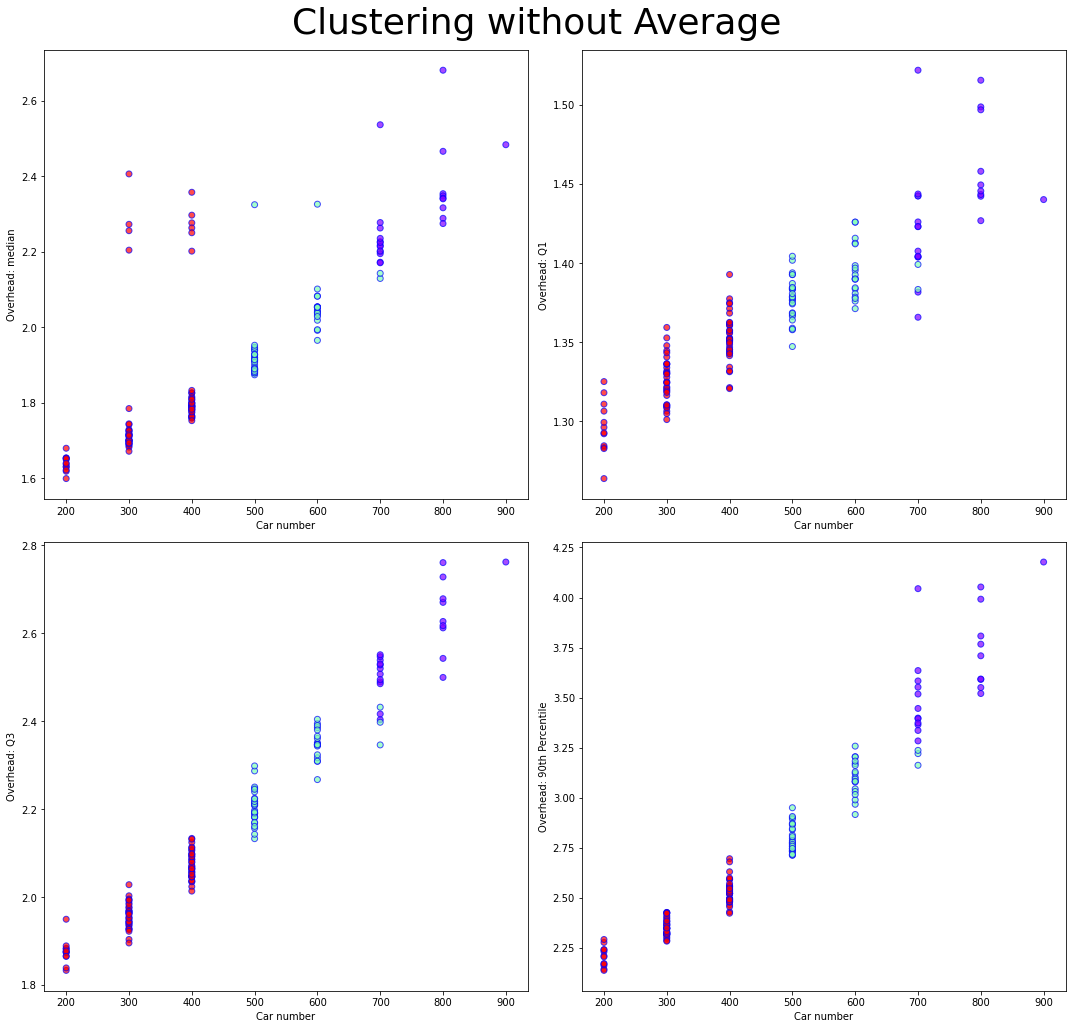

In [35]:
test_data_2 = dropped_data[['q1', 'q3', 'p90']].to_numpy()
test_data_2_list = np.split(test_data_2, 4)
model2 = Birch(n_clusters=None, threshold=0.3)

for i in test_data_2_list:
    model2.partial_fit(i)

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model2, test_data_2, 3, 6)

model2.set_params(n_clusters = n)
model2.partial_fit()
    
labels = model2.predict(test_data_2)
data_to_plott_2 = dropped_data.to_numpy()
figure, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
axs[0,0].scatter(data_to_plott_2[:,4], data_to_plott_2[:,0], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')  
axs[0,0].set_ylabel('Overhead: median')
axs[0,0].set_xlabel('Car number')

axs[0,1].scatter(data_to_plott_2[:,4], data_to_plott_2[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')    
axs[0,1].set_ylabel('Overhead: Q1')
axs[0,1].set_xlabel('Car number')

axs[1,0].scatter(data_to_plott_2[:,4], data_to_plott_2[:,2], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')    
axs[1,0].set_ylabel('Overhead: Q3')
axs[1,0].set_xlabel('Car number')

axs[1,1].scatter(data_to_plott_2[:,4], data_to_plott_2[:,3], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')
axs[1,1].set_ylabel('Overhead: 90th Percentile')
axs[1,1].set_xlabel('Car number')

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
figure.suptitle('Clustering without Average', fontsize=36)

# PCA

In [36]:
scaler = StandardScaler()
scaler.fit(test_data_2)
X=scaler.transform(test_data_2)    


In [37]:
pca = PCA()
x_new = pca.fit_transform(X)

In [38]:
pca.explained_variance_ratio_ #PC1 explains 95% of variance, PC2 explains 3.8% of variance 

array([0.95510356, 0.03871352, 0.00618292])

In [39]:
print(abs( pca.components_ ))

[[0.56702046 0.58208382 0.58280891]
 [0.82350282 0.41622225 0.38548949]
 [0.01819085 0.69852521 0.7153542 ]]


-> First row explains the first principal component for the three features

-> The three features have pretty much similar importance according to PC1

In [121]:
test_data_3 = dropped_data[['q1', 'q3', 'p90']].to_numpy()
test_data_3_list = np.split(test_data_2, 4)


In [134]:
model3 = Birch(n_clusters=None, threshold=0.2)

In [135]:
model3.partial_fit(test_data_3_list[0])
print(model3.subcluster_labels_)
print(model3.subcluster_centers_)

[0 1 2]
[[1.32239969 1.94890159 2.33504313]
 [1.37079185 2.16312608 2.69676251]
 [1.42576401 2.34587941 3.25771968]]


In [136]:
model3.partial_fit(test_data_3_list[1])
print(model3.subcluster_labels_)
print(model3.subcluster_centers_)

[0 1 2 3 4]
[[1.32543615 1.96335936 2.35550472]
 [1.36895022 2.15531059 2.68858972]
 [1.40264238 2.36796445 3.16801212]
 [1.43416475 2.60429741 3.63908617]
 [1.49673252 2.62702278 3.99160123]]


In [137]:
model3.partial_fit(test_data_3_list[2])
print(model3.subcluster_labels_)
print(model3.subcluster_centers_)

[0 1 2 3 4]
[[1.32573855 1.96499966 2.35917607]
 [1.36666476 2.15285211 2.69730695]
 [1.40183686 2.36716492 3.14521397]
 [1.43416475 2.60429741 3.63908617]
 [1.49673252 2.62702278 3.99160123]]


In [138]:
model3.partial_fit(test_data_3_list[3])
print(model3.subcluster_labels_)
print(model3.subcluster_centers_)

[0 1 2 3 4]
[[1.32591583 1.96588083 2.35891863]
 [1.36808632 2.15405795 2.69714217]
 [1.39844326 2.36287896 3.12976276]
 [1.42937371 2.56934982 3.56055837]
 [1.49347299 2.66121726 4.06639362]]


In [140]:
model3.labels_

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 1, 0, 1, 2, 3, 3, 2, 2, 3, 2, 2,
       2, 3, 3, 3, 3, 2, 3, 4, 4, 4, 2, 1, 2, 1, 2, 3])

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


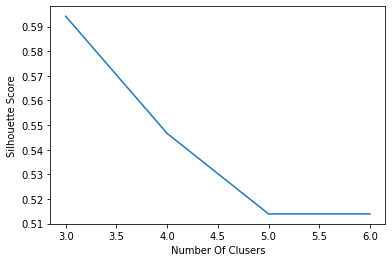

The highest silhouette scores(0.5941766336736833) is for 3 clusers


In [139]:
n = plot_silhouette_scores(model3, test_data_3, 3, 6)

model3.set_params(n_clusters = n)
model3.partial_fit()
    
labels = model3.predict(test_data_3)

In [ ]:
data_to_plott_2 = dropped_data.to_numpy()
figure, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
axs[0,0].scatter(test_data_3[:,4], test_data_3[:,0], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')  
axs[0,0].set_ylabel('Overhead: median')
axs[0,0].set_xlabel('Car number')

axs[0,1].scatter(data_to_plott_2[:,4], data_to_plott_2[:,1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')    
axs[0,1].set_ylabel('Overhead: Q1')
axs[0,1].set_xlabel('Car number')

axs[1,0].scatter(data_to_plott_2[:,4], data_to_plott_2[:,2], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')    
axs[1,0].set_ylabel('Overhead: Q3')
axs[1,0].set_xlabel('Car number')

axs[1,1].scatter(data_to_plott_2[:,4], data_to_plott_2[:,3], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')
axs[1,1].set_ylabel('Overhead: 90th Percentile')
axs[1,1].set_xlabel('Car number')

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
figure.suptitle('Clustering without Average', fontsize=36)